# STA365 HW9
## Lisa Wang

### Q1: copulas

**Question:**

2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

**Q1.2 Answer:**

In [6]:
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as pt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load the dataset 
df = pd.read_csv("HW9_data.csv")  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, b_scale]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'a_mu'}>,
       <Axes: title={'center': 'a_sigma'}>,
       <Axes: title={'center': 'b_scale'}>], dtype=object)

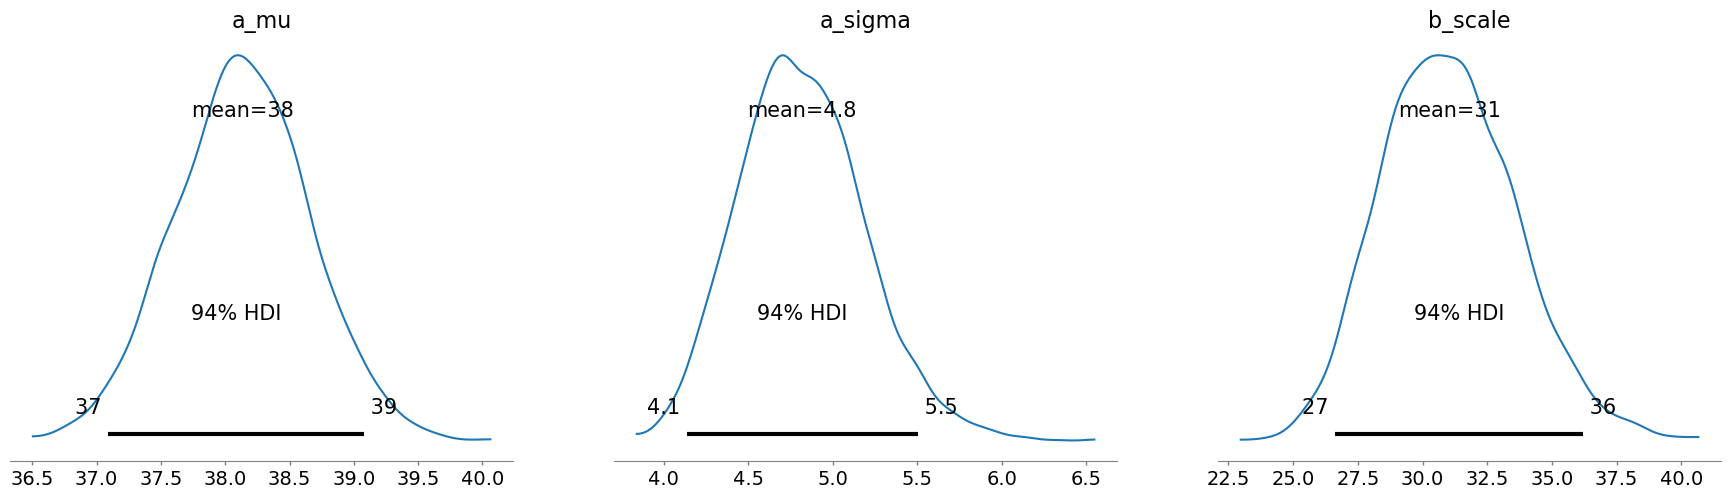

In [4]:
# Fir marginals
# Select the two variables of interest
a = df["percent_adults_with_obesity"].dropna().to_numpy()
b = df["percent_with_access_to_exercise_opportunities"].dropna().to_numpy()

# Ensure they are the same length
n = min(len(a), len(b))
a = a[:n]
b = b[:n]

coords = {"obs_id": np.arange(n)}

with pm.Model(coords=coords) as marginal_model:
    # Estimate Normal for obesity
    a_mu = pm.Normal("a_mu", mu=0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", lam=1)
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=a, dims="obs_id")

    # Estimate Exponential for access to exercise 
    b_shift = np.min(b) - 1e-3  # ensure positive values
    b_adj = b - b_shift
    b_scale = pm.Exponential("b_scale", lam=1)
    pm.Exponential("b", lam=1 / b_scale, observed=b_adj, dims="obs_id")

    trace_marginals = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

az.plot_posterior(trace_marginals, var_names=["a_mu", "a_sigma", "b_scale"])

In [7]:
# Transform & fit the copula model

# Get posterior means from marginal fit
a_mu = trace_marginals.posterior["a_mu"].mean().item()
a_sigma = trace_marginals.posterior["a_sigma"].mean().item()
b_scale = trace_marginals.posterior["b_scale"].mean().item()

# Transform to uniform space (observation -> uniform)
a_unif = stats.norm(loc=a_mu, scale=a_sigma).cdf(a)
b_unif = stats.expon(scale=b_scale).cdf(b_adj)

# Then to multivariate normal space (uniform -> normal)
a_mvn = stats.norm().ppf(a_unif)
b_mvn = stats.norm().ppf(b_unif)

# Stack into Nx2 matrix for multivariate model
copula_data = np.column_stack([a_mvn, b_mvn])

coords.update({"param": ["obesity", "access"], "param_bis": ["obesity", "access"]})

with pm.Model(coords=coords) as copula_model:
    # Prior on correlation structure
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )
    cov = pm.Deterministic("cov", chol @ chol.T, dims=("param", "param_bis"))

    # Likelihood in MVN space
    pm.MvNormal("obs", mu=0, cov=cov, observed=copula_data, dims=("obs_id", "param"))

    trace_copula = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 72 seconds.


array([<Axes: title={'center': 'cov\nobesity, obesity'}>,
       <Axes: title={'center': 'cov\nobesity, access'}>,
       <Axes: title={'center': 'cov\naccess, obesity'}>,
       <Axes: title={'center': 'cov\naccess, access'}>], dtype=object)

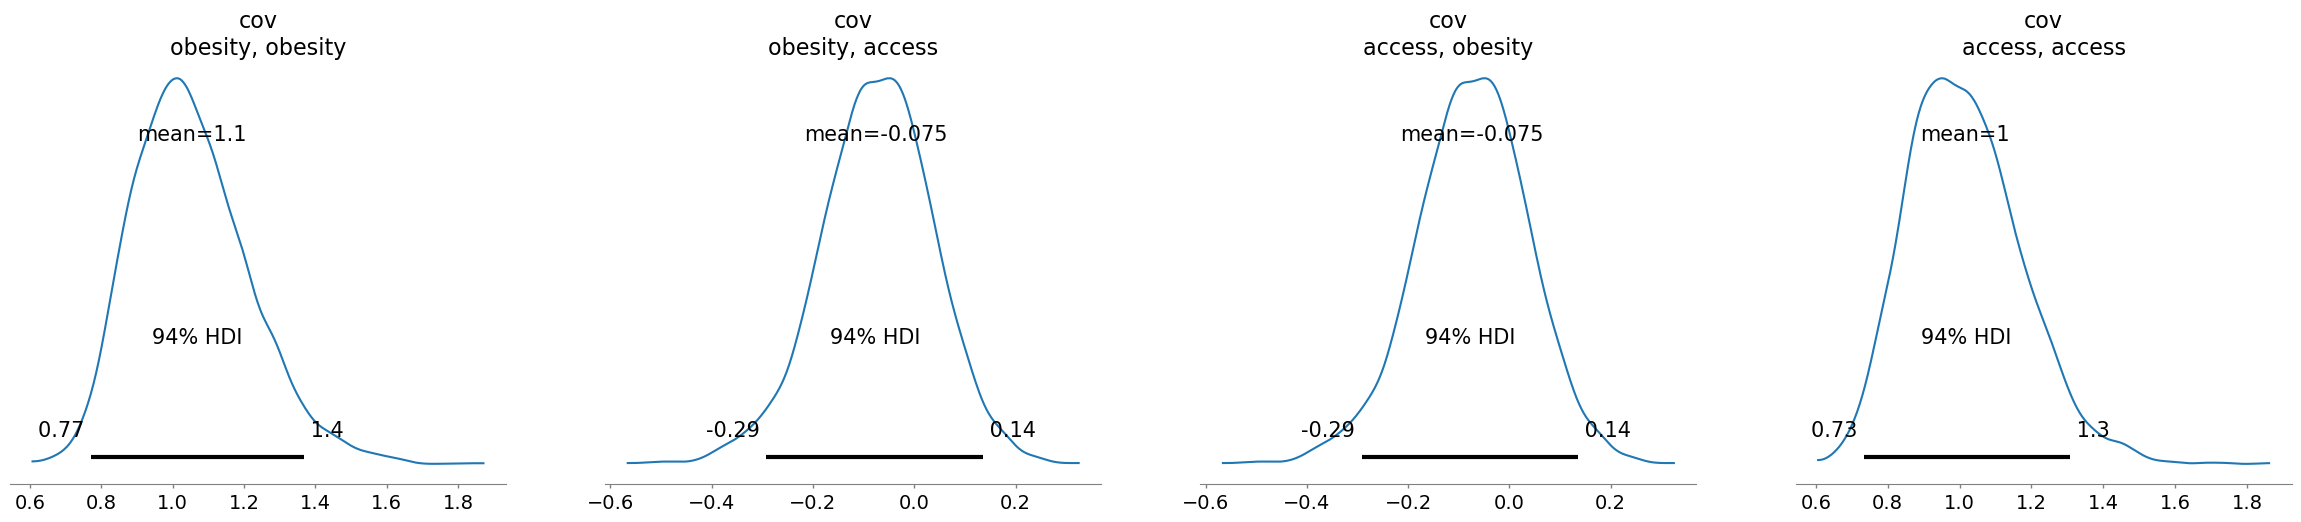

In [8]:
# Visualize copula covariance
az.plot_posterior(trace_copula, var_names=["cov"])

**Q1.3 Answer:**

A copula is a statistical tool used to describe the dependence structure between random variables independently of their marginal distributions. It allows us to construct a joint distribution by combining arbitrary marginals with a chosen dependence structure (where it's often modeled using a multivariate distribution like the multivariate normal). 

The two-pass approach estimates the marginal distributions first using Bayesian inference. Once we obtain the posterior means for the marginal parameters, we transform the observed data from observation space to uniform space, then to the multivariate normal (MVN) space. We then fit a copula model (a multivariate normal with LKJ prior) to estimate the dependence structure.

The alternative approach is the joint modeling approach. It estimates the marginal parameters and copula correlation jointly within a single PyMC model. The transformation from observed space to MVN space is done inside the model. 

Comparing the two approaches, the second one is more compact, but it often suffers from instabiility due to tensor shape complexity and joint parameter sampling. 

**Q1.4 Answer:**

Copulas provide a flexible gramework for building multivariate GLM by allowing us to model each marginal separately with an appropriate link function. It also model the dependency structure between variables using a copula. 

This flexibility is powerful in real-world settings, where different outcome variables may follow different distributions but are still correalted. 

### Q2: Variable Selection using Spike and Slab

**Question:**

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.


In [20]:
# Subset out variable of interest
# First drop NAs, then sample
df_clean = df[[
    "percent_adults_with_obesity", "percent_smokers",
    "per_capita_income", "percent_uninsured",
    "percent_food_insecure", "percent_with_access_to_exercise_opportunities"
]].dropna()

df_sub = df_clean.sample(n=min(100, len(df_clean)), random_state=42)


cols = [
    "percent_adults_with_obesity",     # Y1
    "percent_smokers",                 # Y2
    "per_capita_income",
    "percent_uninsured",
    "percent_food_insecure",
    "percent_with_access_to_exercise_opportunities"
]

Y = df_sub[["percent_adults_with_obesity", "percent_smokers"]].to_numpy()
X = df_sub[[
    "per_capita_income", "percent_uninsured",
    "percent_food_insecure", "percent_with_access_to_exercise_opportunities"
]].to_numpy()

n, p = X.shape
m = Y.shape[1]

In [21]:
import pymc as pm
import numpy as np
import arviz as az

coords = {
    "obs_id": np.arange(n),  # add this line
    "predictors": [f"x{i}" for i in range(p)],
    "responses": [f"y{i}" for i in range(m)]
}


with pm.Model(coords=coords) as ss_model:
    # Spike-and-slab prior
    slab_scale = 10
    spike_scale = 0.1

    inclusion_prob = pm.Beta("inclusion_prob", alpha=1, beta=1)

    # Binary inclusion indicators for each (predictor, response)
    gamma = pm.Bernoulli("gamma", p=inclusion_prob, dims=("predictors", "responses"))

    # Slab and spike priors
    slab = pm.Normal("slab", mu=0, sigma=slab_scale, dims=("predictors", "responses"))
    spike = pm.Normal("spike", mu=0, sigma=spike_scale, dims=("predictors", "responses"))

    # Combine using gamma mask
    coefs = pm.Deterministic("coefs", gamma * slab + (1 - gamma) * spike)

    # Intercept per response
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims="responses")

    # Linear prediction (n x m)
    mu = pm.math.dot(X, coefs) + intercept

    # Likelihood (assume Normal for continuous Y)
    sigma = pm.HalfNormal("sigma", sigma=5, dims="responses")
    pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y, dims=("obs_id", "responses"))

    idata_ss = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [inclusion_prob, slab, spike, intercept, sigma]
>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


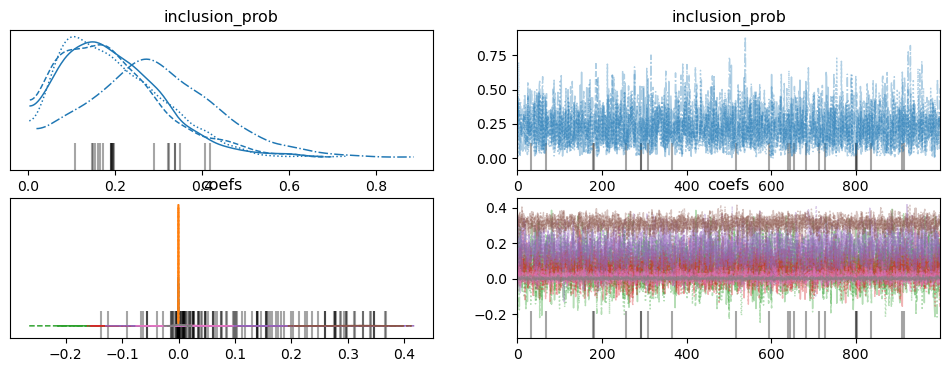

In [22]:
az.plot_trace(idata_ss, var_names=["inclusion_prob", "coefs"]);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


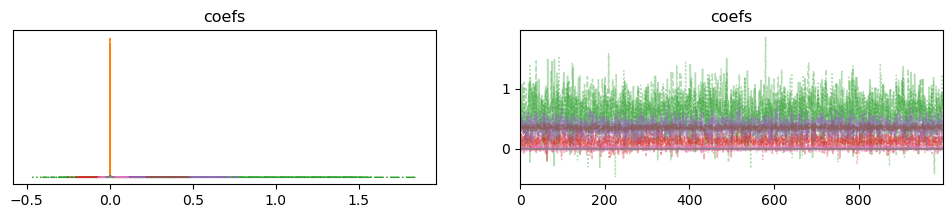

In [23]:
with pm.Model(coords=coords) as diffuse_model:
    # Intercepts for each response
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims="responses")

    # Diffuse normal priors for coefficients
    coefs = pm.Normal("coefs", mu=0, sigma=5, dims=("predictors", "responses"))

    # Linear model
    mu = pm.math.dot(X, coefs) + intercept

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=5, dims="responses")
    pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y, dims=("obs_id", "responses"))

    idata_diffuse = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)


# Visualization
az.plot_trace(idata_diffuse, var_names=["coefs"]);

To investigate variable selection in multivariate regression, I implemented and compared two Bayesian models using the same dataset: one with spike-and-slab priors and one with diffuse normal priors. The response variables were percent_adults_with_obesity and percent_smokers, modeled jointly as a 2-dimensional outcome. Predictors included per_capita_income, percent_uninsured, percent_food_insecure, and percent_with_access_to_exercise_opportunities.

In the spike-and-slab model, each coefficient was modeled using a mixture prior — combining a "spike" (near-zero normal) and a "slab" (wider normal). Inclusion indicators (gamma) determined whether each coefficient was effectively active in the model. This approach provided interpretable variable selection by estimating the posterior inclusion probability for each predictor. In contrast, the diffuse normal model assigned all coefficients standard normal priors with moderate variance ($\sigma$ = 5), representing minimal regularization and no variable exclusion. All predictors were treated equally without any built-in selection mechanism.

The spike-and-slab model favors sparsity and yielded posterior distributions that shrink unimportant coefficients toward zero, making it useful for identifying relevant variables. The diffuse model, while simpler and more stable to fit, includes all predictors by default and is less informative when interpretability and model parsimony are important.

To manage computational demand, I subsampled the dataset to 100 complete observations. As the number of observations, predictors, or response dimensions increases, spike-and-slab models become more computationally intensive.

### Q3:  Variable Selection

**Question:**

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples

In [24]:
with pm.Model(coords=coords) as hs_model:
    # Global scale
    tau = pm.HalfCauchy("tau", beta=1)

    # Local scales (for each coef)
    lambda_ = pm.HalfCauchy("lambda", beta=1, dims=("predictors", "responses"))

    # Coefficients with horseshoe prior
    coefs = pm.Normal("coefs", mu=0, sigma=lambda_ * tau, dims=("predictors", "responses"))

    # Intercepts
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims="responses")

    # Linear predictor
    mu = pm.math.dot(X, coefs) + intercept

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=5, dims="responses")
    pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y, dims=("obs_id", "responses"))

    # Sampling
    idata_hs = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda, coefs, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.


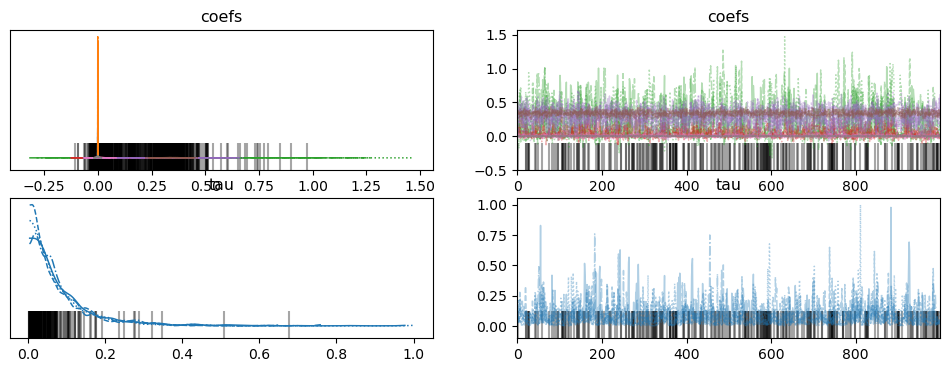

In [25]:
az.plot_trace(idata_hs, var_names=["coefs", "tau"]);

In this question, I implemented a multivariate regression model using the horseshoe prior for variable selection. The same outcome variables (percent_adults_with_obesity and percent_smokers) and predictors were used to allow for a direct comparison of shrinkage behaviors. 

The horseshoe prior employs a combination of a global shrinkage parameter ($\tau$) and local shrinkage parameters ($\lambda$$) for each coefficient. This setup allows the model to strongly shrink most coefficients toward zero, while permitting a few important predictors to escape shrinkage. The posterior trace of coefs shows that many coefficients are tightly concentrated near zero, consistent with the horseshoe’s intended sparsity-inducing effect. The global tau parameter was also relatively small, indicating strong overall regularization across predictors.

Compared to the spike-and-slab model, which uses binary inclusion indicators to explicitly select variables, the horseshoe prior is a continuous shrinkage prior that avoids discrete latent variables. This makes the model more stable and computationally efficient, as reflected by the absence of divergences during sampling. However, interpretability can be slightly lower, as there are no clear "included/excluded" indicators and the importance is inferred from the magnitude of coefficients.